In [1]:
# standard 
import pandas as pd
import numpy as np

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# exploration
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# prepare
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# modeling
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from math import sqrt

# local scripts
from acquire import get_zillow_data
from prepare import prep_zillow
from explore import elbow_method, visual_k, clusters_with_centroids
from model import min_max_scale, rfe, baseline_mean_errors, regression_errors
from model import linear_regression, lasso_lars, polynomial_regression
from model import lr_validate_test, ll_validate_test, pr_validate_test

# Acquire

In [2]:
# cached from local drive to save time
df = pd.read_csv('zillow.csv', index_col=0)

### Summarize

In [38]:
# what's the shape of my data?
df.shape

(73424, 68)

In [114]:
# what features am I working with
# df.columns

In [42]:
# what are my data types?
df.dtypes.value_counts()

float64    56
object     10
int64       2
dtype: int64

In [55]:
print(round(df.isnull().sum(axis=1).sum()/ df.size * 100, 2), '% null values')

48.4 % null values


# Preparation

`prepare.py`
- acquire data from sql
- add county name
- filter for single unit properties
- drop description and other irrelevant columns
- drop columns/rows with over 60% missing values
- split the data into train, validate, test
- replaced nulls for categorical data with mode
- replaced nulls ofr continuous data with median
- renamed some columns for easier reading/writing

In [3]:
train, validate, test = prep_zillow()
train.shape, validate.shape, test.shape

((48799, 17), (13765, 17), (8532, 17))

In [4]:
print('train-->',round(train.shape[0]/len(df)*100, 2),'%')
print('validate-->',round(validate.shape[0]/len(df)*100, 2),'%')
print('test-->',round(test.shape[0]/len(df)*100, 2),'%')

train--> 66.46 %
validate--> 18.75 %
test--> 11.62 %


In [57]:
# categorical variables
cat_vars = [
    "zipcode",
    "county",
    "property_type"
]

In [56]:
# continuous variables
cont_vars = [
    "structure_value",
    "taxamount",
    "home_value",
    "land_value",
    "structure_value",
    "sqft",
    "bathroomcnt",
    "bedroomcnt",
    "lot_sqft",
    "longitude",
    "latitude",
    "yearbuilt"
]

# Exploration

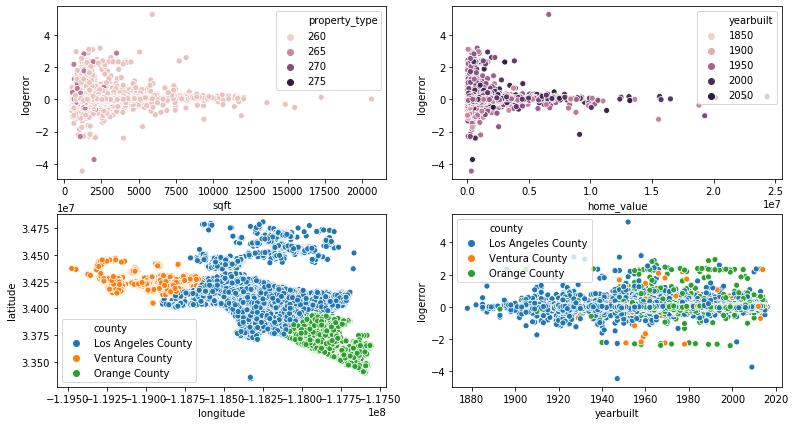

In [92]:
# visualize some relationships
plt.rc('figure', figsize=(13, 7))

plt.subplot(221)
sns.scatterplot(y=train.logerror, x=train.sqft, hue=train.property_type)

plt.subplot(222)
sns.scatterplot(y=train.logerror, x=train.home_value, hue=train.yearbuilt)

plt.subplot(223)
sns.scatterplot(y=train.latitude, x=train.longitude, hue=train.county)

plt.subplot(224)
sns.scatterplot(y=train.logerror, x=train.yearbuilt, hue=train.county)

### Statistical Test

Text(0.5, 1, 'Is the mean logerror significantly greater in Orange County vs all three counties?')

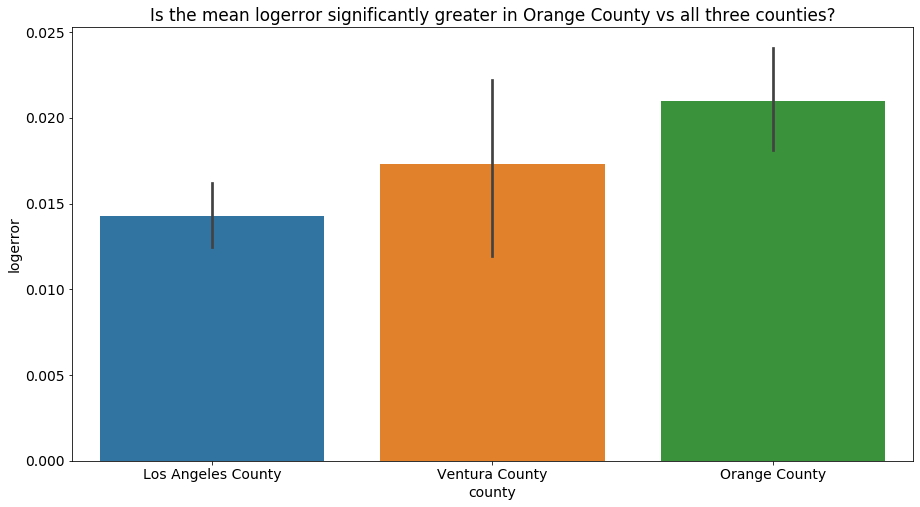

In [95]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=14)
sns.barplot(x=train.county, y=train.logerror)
plt.tight_layout()
plt.title('Is the mean logerror significantly greater in Orange County vs all three counties?')

In [97]:
null = 'mean log error in orange county is less than or equal to the mean log error for all three counties'
alpha = .05

t, p = stats.ttest_1samp(train[train.county == 'Orange County'].logerror, 
                train.logerror.mean())
t, p

(2.892944611987924, 0.003822407816636784)

In [98]:
if p/2 > alpha:
    print("We  fail to reject", null)
elif t < 0:
    print("We fail to reject", null)
else:
    print("We fail to reject", null)

We fail to reject mean log error in orange county is less than or equal to the mean log error for all three counties


*Takeaway: mean log error in orange county isn't greater than the mean log error for all three counties*

### Clustering

#### Home Value and Square Feet

In [59]:
# scale continuous features
scaler = StandardScaler()

# add scaled versions to dataframe
train_scaled = train.copy()
train_scaled[cont_vars] = scaler.fit_transform(train[cont_vars])

# choose features to cluster on
X = train_scaled[['home_value', 'sqft']]

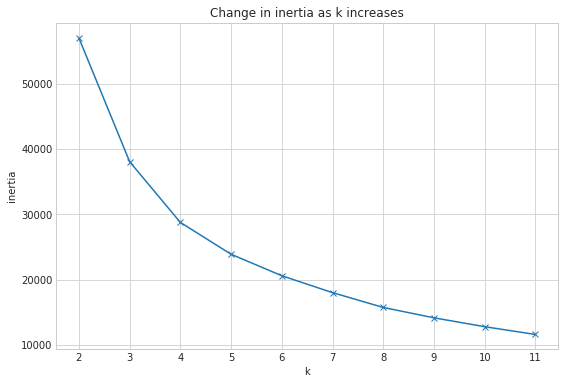

In [60]:
# function: produces elbow method chart
elbow_method(X)

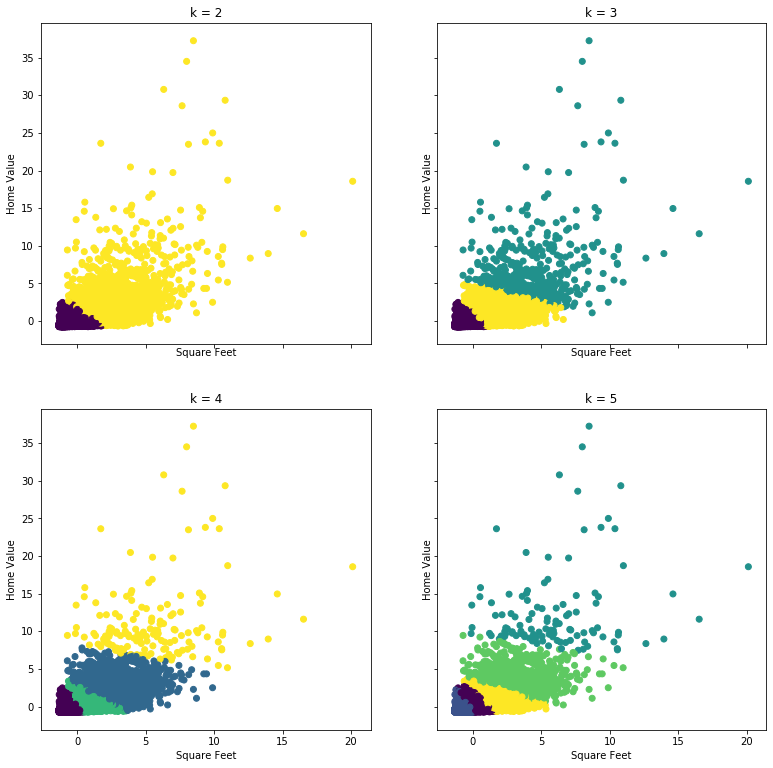

In [61]:
#function: produces visual to determine k by eye
visual_k(X, X.sqft, X.home_value, 'Square Feet', 'Home Value')

In [62]:
# choose k
kmeans = KMeans(n_clusters=3)

# create and fit model
kmeans.fit(X)

# add this cluster set to train_scaled df
train_scaled['cluster_quality'] = kmeans.labels_

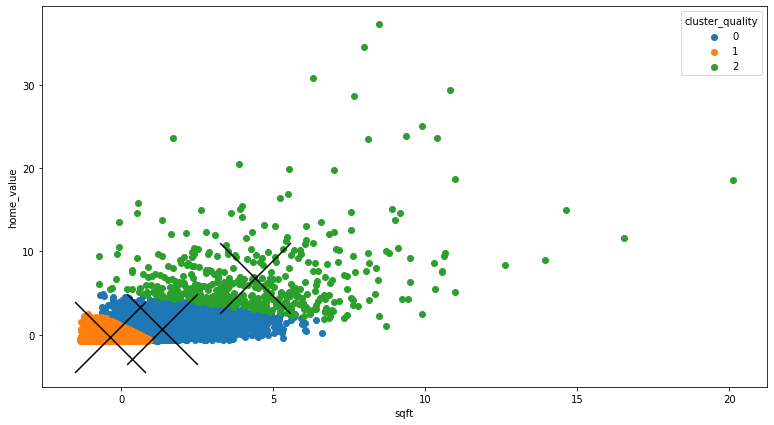

In [74]:
#function: produces the final cluster with centroids
clusters_with_centroids(train_scaled, 'cluster_quality', 
                            'sqft', 'home_value', 
                            'Square Feet', 'Home Value')

#### Bedrooms and Bathrooms

In [75]:
X2 = train_scaled[['bedroomcnt', 'bathroomcnt']]

# choose k
kmeans = KMeans(n_clusters=3)

# create and fit model
kmeans.fit(X2)

# add this cluster set to train_scaled df
train_scaled['cluster_rooms'] = kmeans.labels_

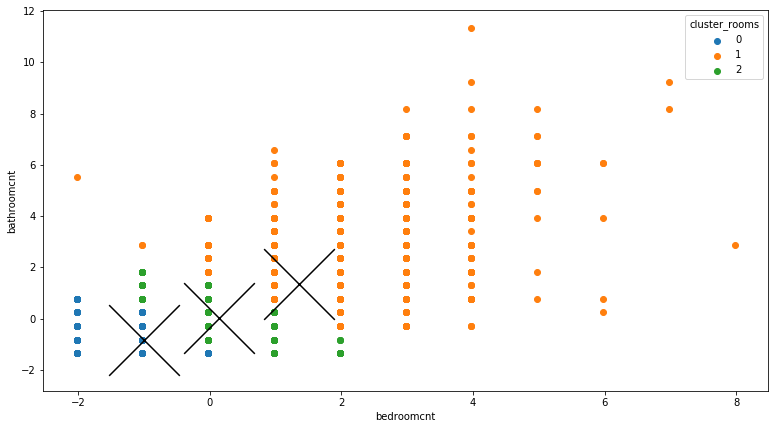

In [76]:
clusters_with_centroids(train_scaled, 'cluster_rooms', 
                            'bedroomcnt', 'bathroomcnt', 
                            'Bedrooms', 'Bathrooms')

#### Year Built and Home Value

In [77]:
X3 = train_scaled[['yearbuilt', 'home_value']]

# choose k
kmeans = KMeans(n_clusters=3)

# create and fit model
kmeans.fit(X3)

# add this cluster set to train_scaled df
train_scaled['cluster_age'] = kmeans.labels_

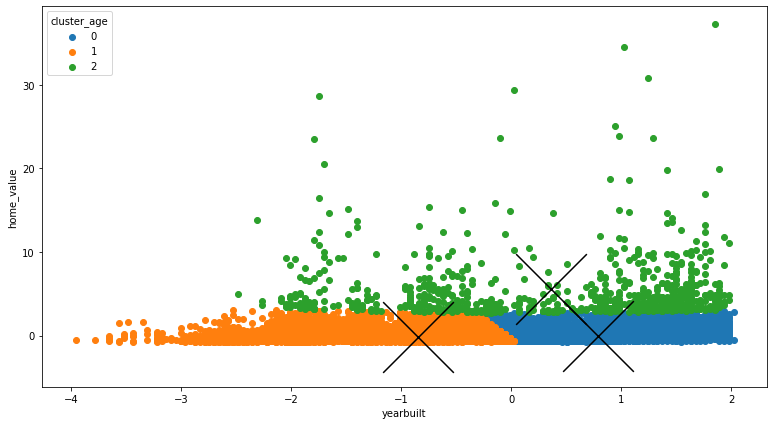

In [78]:
clusters_with_centroids(train_scaled, 'cluster_age', 
                            'yearbuilt', 'home_value', 
                            'Year Built', 'Home Value')

*Takeaways: It looks like cluster 1 is may be a useful one. Ultimately, I am still unsure if these can be beneficial in a model so I won't use any this time*

# Modeling

#### Feature Selection

In [12]:
# select variables for training models
X_train = train.drop(columns=['property_type', 'zipcode', 'transactiondate', 'logerror', 'county'])
X_validate = validate.drop(columns=['property_type', 'zipcode', 'transactiondate', 'logerror', 'county'])
X_test = test.drop(columns=['property_type', 'zipcode', 'transactiondate', 'logerror', 'county'])

# target variable
y_train = train.logerror
y_validate = validate.logerror
y_test = test.logerror

In [13]:
# scale the selected variables
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, 
                                                                 X_validate,
                                                                 X_test)

In [16]:
# reduce to 5 best features using Recursive Feature Elimination
best_features = rfe(X_train_scaled, y_train, 5)
best_features

['sqft', 'structure_value', 'home_value', 'land_value', 'taxamount']

In [17]:
# use top features of RFE to process with modeling
X_train_scaled = train[best_features]
X_validate_scaled = validate[best_features]
X_test_scaled = test[best_features]

#### Baseline

In [103]:
baseline = y_train.mean()
bl_sse, bl_mse, bl_rmse = baseline_mean_errors(y_train)

In [104]:
print('Baseline(mean):', baseline)
print('Baseline RMSE:', bl_rmse)

Baseline(mean): 0.016421615724630675
Baseline RMSE: 0.16544409492851547


#### Linear Regression

In [105]:
lr_rmse = linear_regression(X_train_scaled, y_train)

#### LASSO + LARS

In [106]:
ll_rmse = lasso_lars(X_train_scaled, y_train)

#### Polynomial Regression (2nd degree)

In [107]:
pr2_rmse = polynomial_regression(X_train_scaled, y_train, 2)

#### Polynomial Regression (3rd degree)

In [108]:
pr3_rmse = polynomial_regression(X_train_scaled, y_train, 3)

In [109]:
print("Baseline:", round(bl_rmse, 5))
print("Linear Regression:", round(lr_rmse,5))
print("LassoLars: ", round(ll_rmse, 5))
print("Polynomial, squared:", round(pr2_rmse, 5))
print("Polynomial, cubed:", round(pr3_rmse, 5))

Baseline: 0.16544
Linear Regression: 0.16506
LassoLars:  0.16544
Polynomial, squared: 0.16495
Polynomial, cubed: 0.16479


Top 3 trained models
1. *polynomial cubed* 
2. *polynomial squared*
3. *linear regression*

I will run these models on the validate sets.

In [110]:
# Validate Top 3
lr_rmse_v = lr_validate_test(X_train_scaled, y_train, X_validate_scaled, y_validate)
pr2_rmse_v = pr_validate_test(X_train_scaled, y_train, 2, X_validate_scaled, y_validate)
pr3_rmse_v = pr_validate_test(X_train_scaled, y_train, 3, X_validate_scaled, y_validate)

In [111]:
print("Polynomial, cubed:", round(pr3_rmse_v, 5))
print("Polynomial, squared:", round(pr2_rmse_v, 5))
print("Linear Regression:", round(lr_rmse_v,5))

Polynomial, cubed: 0.16844
Polynomial, squared: 0.16767
Linear Regression: 0.16775


In [112]:
# Test the top model
lr_rmse_t = lr_validate_test(X_train_scaled, y_train, X_test_scaled, y_test)

In [113]:
print("Linear Regression:", round(lr_rmse_t,5))

Linear Regression: 0.1747


# Conclusion

- I didn't find any useful clusters
    - more experience and research
    - encoding to be able to scale with other features
- log error doesn't have any obvious realtionship with my current features
    - It may have been helpful to explore more and create new ones
- outliers should have been handled
    - they may have skewed the data enough to end up with bad models